### TEAM ID                         : 5A10 
#### SEMESTER                                : 5
#### DIVISION                        : A  
#### SCHOOL                         : School of Computer Science Engineering
### COURSE                    : Data Mining and Analysis
### COURSE CODE         : 18ECSC301
#### TOPIC ID                         : 5ADMACP16
### PROJECT TITLE             : Cold Start Energy Forecasting
#### PROBLEM STATEMENT : To forecast the consumption of energy for each hour, day and week, given the temperature and building information.
#### TEAM LEADER                : Hemanth H. K. 
#### MEMBERS -                       
####                                            38     Apoorva Hegde    01FE16BCS040
####                                            65     Ganesh Jadhav    01FE16BCS070
####                                            66     Girish Illanad        01FE16BCS071
####                                            67     Hemanth H. K.      01FE16BCS073


### Reviewing the Dataset

   1. **consumption_train.csv**  – This dataset contains data on cold start measurements of building consumption data (in watt-hours) and temperature. The cold start data is provided at an hourly time step over a period of anywhere from 1 day to 2 weeks. Cold start data only comes in full days This is the primary dataset used to train the model.
   
    
   2. **cold_start_test.csv** – This dataset also contains data on cold start measurements of building consumption data (in watt-hours) and temperature, in the same format as consumption_train.csv. These are the series_ids for which final prediction model need to be tested.
   
   
   3. **meta.csv** – This data is supplementary data that can be used to train the model and make the final predictions. It contains information about the holidays (e.g.sunday is holiday.) in both the testing and training datasets.
   
   
   4. **submission_format.csv** -This is the format in which the prediction consumtion values is to be submitted.
   
  ### NOTE 
  - Temperature is in degree celsius.
  - Energy consumption in watt-hours.


In [ ]:
#importing the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline 
from pandas.tools.plotting import autocorrelation_plot
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from math import sqrt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import KFold, cross_val_score


### DATA PREPROCESSING
#### [1] DATA CLEANING 

In [ ]:
#reading the consumption_train.csv 
train_data = pd.read_csv('cold_start_train.csv')
#Extracting the columns from the training data.
train_data = train_data.loc[:,["series_id","timestamp","consumption","temperature"]] 
train_data.head()

In [ ]:
#reading the  cold_start_test.csv
test_data = pd.read_csv('cold_start_test.csv')
#Extracting the columns from testing data.
test_data = test_data.loc[:,['series_id','timestamp','consumption','temperature']]
test_data.head()

In [ ]:
#reading the  meta.csv
meta_data = pd.read_csv('meta.csv')
meta_data.head()

#### [2]DATA INTEGRATION

In [ ]:
#concatenating the training and the testing data
train_all = pd.concat((train_data, test_data), axis = 0, ignore_index = True, sort = False)
train_all.head()

In [ ]:
#checking the size of all the datasets
print(train_data.shape)
print(test_data.shape)
print(train_all.shape)

In [ ]:
#finding the number of unique series id's in all datasets
def findUnique(df):
    print(df.nunique())
    print("---------------------------------------------------")
findUnique(train_data)
findUnique(test_data)
findUnique(train_all)
findUnique(meta_data)

#### INFERENCE
#### The combination of the  number of series id's in training and testing is equal to that in meta data. 

In [ ]:
#finding the misssing values in all datasets
def findMissingValues(df):
    print(df.isnull().sum()*100/df.shape[0])
    print("---------------------------------------------------")

findMissingValues(train_data)
findMissingValues(test_data)
findMissingValues(train_all)
findMissingValues(meta_data)


#### INFERENCE
#### The missing temperature values in our entire training data is 44% approx. 

In [ ]:
#Converting time datatypes to the standard format
print(train_all.dtypes)
train_all['timestamp'] = pd.to_datetime(train_all.timestamp)
print(train_all.dtypes)

#### [3] DATA TRANSFORMATION

In [ ]:
#breaking the timestamp into minutes, hours, weekday, day of the year, day of the month, month, and year
def process_time(df):
    
    # Convert timestamp into a pandas datatime object
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    
    # Extract units of time from the timestamp
    df['min'] = df.index.minute
    df['hour'] = df.index.hour
    df['wday'] = df.index.dayofweek
    df['mday'] = df.index.day
    df['yday'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    # Create a time of day to represent hours and minutes
    df['time'] = df['hour'] + (df['min'] / 60)
    df = df.drop(columns=['hour', 'min'])
        
    # turn the index into a column
    df = df.reset_index(level=0)
    
    return df
  
# Feature engineering of the time for train and test
train_all = process_time(train_all)
train_all.drop(columns = 'timestamp', inplace = True)
train_all.head()

In [ ]:
#he time variables are then converted to cyclical features to preserve the proper relationships between times
def process_time2(df):
    # wday has period of 6
    df['wday_sin'] = np.sin(2 * np.pi * df['wday'] / 6)
    df['wday_cos'] = np.cos(2 * np.pi * df['wday'] / 6)
    
    
    # yday has period of 365
    df['yday_sin'] = np.sin(2 * np.pi * df['yday'] / 365)
    df['yday_cos'] = np.cos(2 * np.pi * df['yday'] / 365)
    
    # month has period of 12
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # time has period of 24
    df['time_sin'] = np.sin(2 * np.pi * df['time'] / 24)
    df['time_cos'] = np.cos(2 * np.pi * df['time'] / 24)

    return df

train = process_time2(train_all)
train.head()

In [ ]:
## Create a new dataframe for the series id from meta data
id_list = set(meta_data['series_id'])
all_meta = pd.DataFrame(columns=['series_id', 'wday', 'off'])
all_meta=all_meta.astype(int)
len(id_list)

In [ ]:
# Iterate through each series id and find days off
for id in id_list:
    # Extract the metadata information for the series id
    meta_slice = meta_data.ix[meta_data['series_id'] == id]
    
    # Create a new dataframe for the series id
    building_meta = pd.DataFrame(columns=['series_id', 'wday', 'off'],
                            index = [0, 1, 2, 3, 4, 5, 6])
    
    building_meta['wday'] = [0, 1, 2, 3, 4, 5, 6]
    building_meta['series_id'] = id
    
    # Record the days off
    building_meta.ix[0, 'off'] = float(meta_slice['monday_is_day_off'])
    building_meta.ix[1, 'off'] = float(meta_slice['tuesday_is_day_off'])
    building_meta.ix[2, 'off'] = float(meta_slice['wednesday_is_day_off'])
    building_meta.ix[3, 'off'] = float(meta_slice['thursday_is_day_off'])
    building_meta.ix[4, 'off'] = float(meta_slice['friday_is_day_off'])
    building_meta.ix[5, 'off'] = float(meta_slice['saturday_is_day_off'])
    building_meta.ix[6, 'off'] = float(meta_slice['sunday_is_day_off'])
    
    # Append the resulting dataframe to all site dataframe
    all_meta = all_meta.append(building_meta) 
    
# merging(left join) back to the orignal meta data
train = train_all.merge(all_meta, how = 'left', on = ['series_id','wday'])
train.head()

In [ ]:
#preparing to merge the training data and testing with meta
left = train
right  = meta_data.loc[:,["series_id","surface","base_temperature"]] 
print(left.head())
print(right.head())
print(left.shape)
print(right.shape)


In [ ]:
#checking the  training data after merging with train, test with meta data.
merged_data = pd.merge(left,right,on = 'series_id')
merged_data.head()

In [ ]:
#Comparing the unique attributes
findUnique(merged_data)

In [ ]:
#working with the categorical data
print(merged_data.surface.value_counts())
print(merged_data.base_temperature.value_counts())

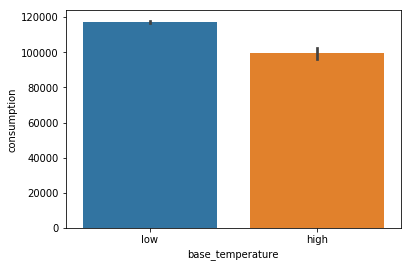

In [22]:
#understanding the relation between base temperature and label
g = sns.barplot(x="base_temperature",y="consumption",data=merged_data)
g = g.set_ylabel("consumption")

#### INFERENCE
#### The high/low temperature in the base temperature doesnt imply any relation with target

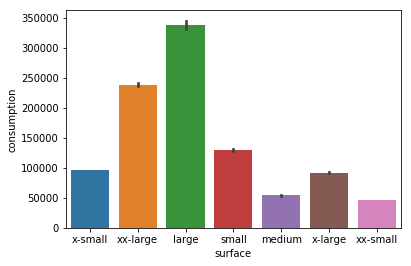

In [23]:
#understanding the relation between surface and label
g= sns.barplot(x="surface",y="consumption",data=merged_data)
g = g.set_ylabel("consumption")

#### INFERENCE
#### The surface (buildings) marked - 'large' consume the most energy 

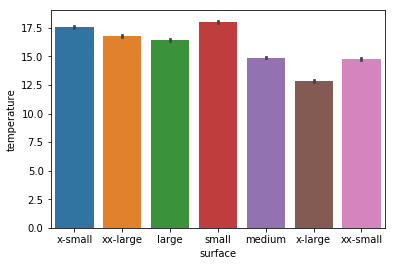

In [26]:
#finding the relation between surface and temperature
g = sns.barplot(x="surface",y="temperature",data=merged_data)
g = g.set_ylabel("temperature")

#### INFERENCE
#### The smaller the  surface has higher the temperature 

In [ ]:
#defining functions to find maximum and minimum for attributes in dataFrame
d = merged_data
def findMinMax(df,col):
    print("Extremes for ",col )
    print( df.groupby(col).apply(lambda x: x.temperature[x.temperature.idxmax()]))
    print(df.groupby(col).apply(lambda x: x.temperature[x.temperature.idxmin()]))
def findMinMaxConsumption(df,col):
    print("Extremes for ",col )
    print( df.groupby(col).apply(lambda x: x.consumption[x.consumption.idxmax()]));
    print(df.groupby(col).apply(lambda x: x.consumption[x.consumption.idxmin()]));

In [ ]:
#finding maximum and minimum for surface and base temperature in dataFrame
a1 = findMinMax(d, "surface")
a2 = findMinMax(d, "base_temperature")
a3 = findMinMaxConsumption(d, "surface")
a4 = findMinMaxConsumption(d, "base_temperature")

In [ ]:
#one hot encoding the surface column
def convert_to_binary(df, column_to_convert):
    categories = list(df[column_to_convert].drop_duplicates())

    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert[:5] + '_' + cat_name[:10]
        df[col_name] = 0
        df.loc[(df[column_to_convert] == category), col_name] = 1

    return df
columns_to_convert = ['surface']

for column in columns_to_convert:
    merged_data = convert_to_binary(df=merged_data, column_to_convert=column)
    merged_data.drop(column, axis=1, inplace=True)
merged_data.head()

In [ ]:
#mapping the values in base temperature to 0 and 1(high) and creating a new attribute base num
merged_data['base_num'] = merged_data.base_temperature.map({'high':1, 'low':0});
#dropping the base temperature since its corresponding values are already in base-num
merged_data.drop(columns = 'base_temperature', inplace = True)
print(merged_data.shape)
merged_data.head()


#### INFERENCE
#### The combination of all data sets leaves us with a total of 26 attributes.. 

#### [4]OUTLIER CHECK

In [ ]:
#Finding the outliers in training data.
#For temperature:
print('Maximum temperature in training data:',merged_data.temperature.max())
print('Minimum temperature in training data":',merged_data.temperature.min())
print('\n')
#For consumption:
print('Maximum consumption in training data:',merged_data.consumption.max())
print('Maximum consumption in training data:',merged_data.consumption.min())
print('\n')
x = 0.80*merged_data.consumption.max()
print("Max: ", x)
print('Number of tuples with greater than 80% of max consumption: ',merged_data[merged_data.consumption>x]["consumption"].count()) #Considering values 80% as threshold.
df = merged_data
train_high = df[df.consumption>x]["consumption"]


### Inference: 
Given the temperature's range, its neiter too hot nor too cold to be termed as outliers. Hence we find no outliers in temperature.<br> 
Given the consumption's range, most of the id's(buildings) i.e atleast 100 have consumption more than normal, but they might be industries or factories which might consume more power . Hence we find no outliers in consumption.


#### [5]HANDLING MISSING DATA

In [ ]:
#finding the missing values
merged_data.isnull().sum()*100/merged_data.shape[0]

In [ ]:
#savaing the dataframe before experimenting on it.
train = merged_data

In [ ]:
#grouping the series id, month and year and fill missing temperature
train["temperature"] = train.groupby(["series_id","month","year"]).temperature.transform(lambda x: x.fillna(x.mean()))
train.isnull().sum()*100/train.shape[0]

In [ ]:
#grouping the series id and year and fill missing temperature with mean
train["temperature"] = train.groupby(["series_id","year"]).temperature.transform(lambda x: x.fillna(x.mean()))
train.isnull().sum()*100/train.shape[0]

In [ ]:
#grouping the series id and fill missing temperature with mean
train["temperature"] = train.groupby(["series_id"]).temperature.transform(lambda x: x.fillna(x.mean()))
train.isnull().sum()*100/train.shape[0]

### Inference: 
#### The total missing values after filling via groupby is still ~34%. We shall make use of machine learning to fill in the rest.

In [ ]:
#Seperating the the tuples with missing temperature 
data_null=train[pd.isnull(train['temperature'])]
data_null.head()

In [ ]:
#seperated dataframe has no values for temperature column
data_null.isnull().sum()*100/data_null.shape[0]

In [ ]:
#dropping the rows in the training data that were missing  
train.dropna(inplace=True) 

In [ ]:
#extracting required features that'll be needed to fill missing temperature(acts as a label here now)
x= train.loc[:,['series_id','base_num','wday_sin','wday_cos','yday_sin','wday_cos','month_sin','month_cos','time_sin','time_cos']]
print(x.head())
x1= data_null.loc[:,['series_id','base_num','wday_sin','wday_cos','yday_sin','wday_cos','month_sin','month_cos','time_sin','time_cos']]
print(x1.head())

In [ ]:
#taking the label.
y=train[['temperature']]
print(y.head())
y1=data_null[['temperature']]
print(y1.head())


### Analysis: 
Given the data is non linear, linear models will not fit properly.Hence using ensemble methods will be appropriate.
<br>Of all ensemble methods randomforestregressor gave best results. We proceed with the same model to fill temperature

In [ ]:
#Training model to fill the missing temperature values considering other features.
lr = RandomForestRegressor(max_depth=30 , random_state=0,n_estimators=100)   
lr.fit(x, y)

y0_predict=lr.predict(x1)
print(y0_predict)

In [ ]:
#dropping the temperature column so to add the last predicted one.
data_null.drop('temperature',axis=1, inplace = True)
data_null.head()
data_null.shape

In [ ]:
#Adding predicted temperature to the dataframe
data_null['temperature']=y0_predict
data_null.head()

In [ ]:
frames = [train,data_null]

In [ ]:
#merging back the filled temperature back to the original training dataframe
data = pd.concat(frames)

In [ ]:
#finding the size of dataframe after feature engineering
data.shape

In [ ]:
#finding the correlation between the attributes
merged_data.corr()

In [ ]:
#dropping the attributes that are already converted into cyclic.
df =data.drop(columns=['month','mday','wday','yday','time'])
df.columns

In [ ]:
# Correlation matrix between numerical values  
plt.figure(figsize = (25,15))
g = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [ ]:
#finding the correlation with target
df.corr()['consumption']

In [ ]:
#performing the chisquare tests 
lm1 = smf.ols(formula='consumption ~ base_num+month_cos+month_sin+off+series_id+surfa_large+surfa_medium+surfa_small+surfa_xlarge+surfa_xsmall+surfa_xxlarge+surfa_xxsmall+temperature+time_cos+time_sin+wday_cos+wday_sin+yday_cos+yday_sin+year',data=df).fit()

# print the coefficients
lm1.params
lm1.summary()

### Inference: 
The correlation heatmap and the chi square tests indicate that yday_cos-month_cos, yday_sin-month_sin and temperature-month_cos are highly correlated. Comparing them with target we drop month_cos, yday_sin will be dropped along with the target(for training).

In [ ]:
#prepring to fit the model
X= data.drop(columns=['consumption','month','wday','mday','yday','time','month_cos', 'yday_sin'])
X.reset_index()
print(X.head())
y = data.consumption
print(y.head())


### MODEL BUILDING

In [ ]:
## Spliting of training dataset into 70% training data and 30% testing data randomly
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1)


In [ ]:
#preparing to fit the model.
x = features_train
y = labels_train
x1 = features_test
y1 = labels_test

In [ ]:
lr = LinearRegression()
lr.fit(x, y)
y0_predict=lr.predict(x1)
print(r2_score(y1, y0_predict) )#linear regression

In [ ]:
rr = Ridge(alpha=0.001)
rr.fit(x, y)
y1_predict=rr.predict(x1)
print(r2_score(y1, y1_predict) ) #ridge with low alpha

In [ ]:
lasso = Lasso()
lasso.fit(x,y)
y3_predict=lasso.predict(x1)
print(r2_score(y1, y3_predict) )

#### ANALYSIS:
The score is low because of the non linear behavior of the data. 

In [ ]:
#fitting model on baggingregressor
rf = sklearn.ensemble.BaggingRegressor(n_estimators=500, n_jobs=1, verbose=10)
rf.fit(x, y)
print(r2_score(y1, rf.predict(x1)))


In [ ]:
#fitting the model on extratreesregressor with max depth =30
rf = sklearn.ensemble.ExtraTreesRegressor(n_estimators=500, max_depth=30)
rf.fit(x, y)
print(r2_score(y1, rf.predict(x1)))


In [ ]:
#fitting model on baggingregressor
rf = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
rf.fit(x, y)
print(r2_score(y1, rf.predict(x1)))

In [ ]:
#fitting with  RandomForestRegressor  for testing data
regr = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
regr.fit(x, y)
y12_predict = regr.predict(x1)
print(r2_score(y1, y12_predict) ) #Random forest regressor

In [ ]:
#fitting with  RandomForestRegressor for training data
regr = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
regr.fit(x, y)
y13_predict = regr.predict(x)
print(r2_score(y, y13_predict) ) #Random forest regressor

### INFERENCE
#### Ensemble methods did actually work well compared to the linear models. We use randomforest and extratreesregressor to further evaluate it.

### POST PROCESSING

In [ ]:
#evaluating the model
train_accuracy_list = []
test_accuracy_list = []

for i in range(5,30):
    regr = RandomForestRegressor(max_depth=i, random_state=0,n_estimators=100)
    regr.fit(x, y)
    y13_predict = regr.predict(x)
    print("Training error for depth = ", i , " : " ,r2_score(y, y13_predict) ) #Random forest regressor
    train_accuracy_list.append(r2_score(y, y13_predict))
    y11_predict = regr.predict(x1)
    print("Testing error for depth = ", i , " : ",r2_score(y1, y11_predict) ) #Random forest regressor
    test_accuracy_list.append(r2_score(y1, y11_predict))

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


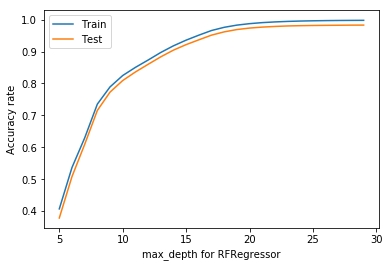

In [66]:
#creating a dummy list
list1= list(range(5, 30))
#plotting the learning curve on basis of max depth
plt.plot(list1 , train_accuracy_list , label = "Train")
plt.plot(list1 , test_accuracy_list, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("max_depth for RFRegressor")
plt.ylabel("Accuracy rate")
plt.show()
#plt.plot(list1 , train_accuracy_list)

### INFERENCE
#### The plot shows that the score of the model increases with increasing depth. At depth = 30, we get max score for both training and testing data.
#### It fits perfectly for both training and testing data(low bias and low variance).

In [ ]:
#evaluating the model on varying basis of max depth of RandomForestRegressor
train_accuracy_list2 = []
test_accuracy_list2 = []

for i in range(5,30):
    regr = RandomForestRegressor(max_depth=i, random_state=0,n_estimators=100)
    regr.fit(x, y)
    y13_predict = regr.predict(x)
    print("Training error for depth = ", i , " : " ,sqrt(metrics.mean_squared_error(y, y13_predict)) ) #Random forest regressor
    train_accuracy_list2.append( sqrt(metrics.mean_squared_error(y, y13_predict)))
    y11_predict = regr.predict(x1)
    print("Testing error for depth = ", i , " : ",sqrt(metrics.mean_squared_error(y1, y11_predict)) ) #Random forest regressor
    test_accuracy_list2.append( sqrt(metrics.mean_squared_error(y1, y11_predict)))

print(len(train_accuracy_list2))
print(len(test_accuracy_list2))

#plt.plot()

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


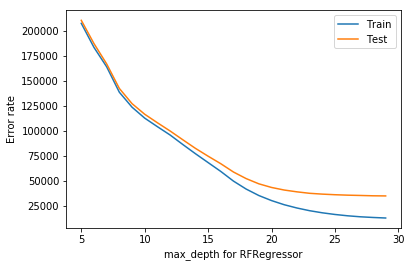

In [68]:
#plotting the bias variance curve on basis of max depth for randomforestregressor
plt.plot(list1 , train_accuracy_list2 , label = "Train")
plt.plot(list1 , test_accuracy_list2, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("max_depth for RFRegressor")
plt.ylabel("Error rate")
plt.show()

### INFERENCE
#### The plot shows that the error of the model decreases with increasing depth. At depth = 30, we get min error for both training and testing data.
#### It fits perfectly for both training and testing data(low bias and low variance).

In [ ]:
#evalutaing model on basis of varying depth of ExtraTreesRegressor
train_accuracy_list2 = []
test_accuracy_list2 = []

for i in range(5,30):
    regr = sklearn.ensemble.ExtraTreesRegressor(n_estimators=500, max_depth=i)
    regr.fit(x, y)
    y13_predict = regr.predict(x)
    print("Training error for depth = ", i , " : " ,sqrt(metrics.mean_squared_error(y, y13_predict))) #Random forest regressor
    train_accuracy_list2.append( sqrt(metrics.mean_squared_error(y, y13_predict)))
    y11_predict = regr.predict(x1)
    print("Testing error for depth = ", i , " : ",sqrt(metrics.mean_squared_error(y1, y11_predict))) #Random forest regressor
    test_accuracy_list2.append( sqrt(metrics.mean_squared_error(y1, y11_predict)))

print(len(train_accuracy_list2))
print(len(test_accuracy_list2))

#plt.plot()

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


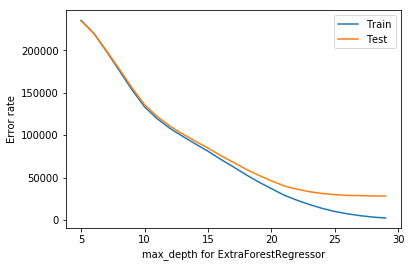

In [72]:
#plotting the bias variance curve on basis of max depth for extratreesregressor
plt.plot(list1 , train_accuracy_list2 , label = "Train")
plt.plot(list1 , test_accuracy_list2, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("max_depth for ExtraForestRegressor")
plt.ylabel("Error rate")
plt.show()

### INFERENCE
#### The plot shows that the error of the model decresases with increasing depth. At depth = 30, we get min error for both training and testing data.
#### It fits perfectly for both training and testing data(low bias and low variance).

In [ ]:
#performing kfold cross validation for randomforestregressor on max depth =10
k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
clf = RandomForestRegressor(max_depth=10, random_state=0,n_estimators=100)
print (cross_val_score(clf, x, y, cv=k_fold, n_jobs=1))

In [ ]:
#performing kfold cross validation for randomforestregressor max depth =30
k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
clf = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
print (cross_val_score(clf, x, y, cv=k_fold, n_jobs=1))

In [ ]:
#performing kfold cross validation ExtraTreesRegressor on max depth =30
k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
clf = sklearn.ensemble.ExtraTreesRegressor(n_estimators=500, max_depth=30)
print (cross_val_score(clf, x, y, cv=k_fold, n_jobs=1))

### INFERENCE
#### The cross validation results give postive and expected results.

In [ ]:
#Creating dummy lists 
train_accuracy_list3 = []
test_accuracy_list3 = []
inc3 = []
#defining a funtion to plot bias variance curve.
def BVCurve():
    minimum = 10000
    inc = int(x.shape[0]/5)
    maximum = x.shape[0]
    regr = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
    for i in range(minimum, maximum, inc):
        regr.fit(x[0:i], y[0:i])
        y13_predict = regr.predict(x[0:i])
        print(len(x[0:i]), len(y[0:i]), len(y13_predict))
        print("Training error for data of size = ", i , " : " ,sqrt(metrics.mean_squared_error(y[0:i], y13_predict)) ) #Random forest regressor
        train_accuracy_list2.append( sqrt(metrics.mean_squared_error(y[0:i], y13_predict)))
        y11_predict = regr.predict(x1[0:i])
        print("Testing error for data of size = ", i , " : ",sqrt(metrics.mean_squared_error(y1[0:i], y11_predict)) ) #Random forest regressor
        test_accuracy_list2.append( sqrt(metrics.mean_squared_error(y1[0:i], y11_predict)))
        inc3.append(i)


BVCurve()
print(len(train_accuracy_list3))
print(len(test_accuracy_list3))
print(len(inc3))

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


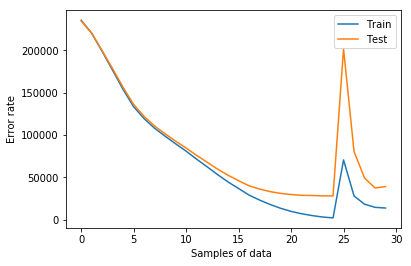

In [82]:
#plotting bias variance curve for RandomForestRegressor on varying samples of data
inr=list(range(30))
plt.plot(inr , train_accuracy_list2 , label = "Train")
plt.plot(inr , test_accuracy_list2, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("Samples of data ")
plt.ylabel("Error rate")
plt.show()

### CONCLUSIONS:
#### The meta data had important attributes that played important role.
#### The only attribute with missing values was the  temperature; it was first filled via groupby and later with machine learning.
####  The ensembe methods fit best than the linear models because of the non linear property of data.
#### The randomforestregressor and extratreesregressor gave score of 98.27 and 98.9 respectively and were better among all other ensemble techniques
#### The learning curves fit(neither underfit not overfit) well for both training and testing for both the models mentioned above.
#### The extratreesregressor would be used for prediction because of the accuracy and the fit over the validation curves.

# Method 2: LSTM

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path 
from numpy.random import seed
from tensorflow import set_random_seed
RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

In [ ]:
import sys
sys.path.append("numpy_path")

## DATA PREPROCESSING (Date time parsing and normalization)

#### [1]Date Time Parsing

In [ ]:
train_data = pd.read_csv('consumption_train.csv',index_col=0, parse_dates=['timestamp'])
test_data = pd.read_csv('cold_start_test.csv',index_col=0, parse_dates=['timestamp'])
sub_data = pd.read_csv('submission_format.csv',index_col='pred_id',parse_dates=['timestamp'])

train_data = train_data.loc[:,["series_id","timestamp","consumption","temperature"]] 
test_data = test_data.loc[:,['series_id','timestamp','consumption','temperature']]

sub_data = sub_data.loc[:,['series_id','timestamp','temperature','consumption','prediction_window']]

#### [2]Creating Lagged Features 

In [ ]:
def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['consumption'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

# example series
test_series = train_data[train_data.series_id == 100283]
create_lagged_features(test_series.consumption, lag=3).head()

#### [3]Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

_X, _y, scaler = prepare_training_data(test_series.consumption, 5)
print(_X.shape)
print(_y.shape)
print(scaler)


In [ ]:
# modeling
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# progress bar
from tqdm import tqdm

## Post Processing

### Long short-term memory (LSTM)

##### LSTM units are units of a recurrent neural network (RNN)  well-suited to classifying, processing and making predictions based on time series data

In [ ]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  24

# model parameters
num_neurons = 24
batch_size = 1  # this for`ces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
%%time
num_training_series = train_data.series_id.nunique()
num_passes_through_data = 3

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in train_data.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

In [ ]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(consumption.values.reshape(-1, 1))[-lag:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, lag), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

### [1]Predicting for submission format

In [ ]:
# copy submission format and fill in values
my_submission = sub_data.copy()

In [ ]:
mytest = test_data

In [ ]:

%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = test_data[test_data.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

In [ ]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

In [ ]:
my_submission.head(5)

In [ ]:
my_submission.to_csv("my_submmission.csv", index_label='pred_id')

### [2]Predicting for test data

In [ ]:

%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = mytest.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(mytest.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = 1
    num_pred_hours = 1
    
    # prepare cold start data
    series_data = test_data[test_data.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(1, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    #reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = mytest.series_id == ser_id
    mytest.loc[ser_id_mask, 'consumption'] = preds

In [ ]:
mytest.consumption

###### Accuracy for test data

In [ ]:
from sklearn.metrics import r2_score
r2_score(y1, y0) 

### [2]Predicting on Train data

In [ ]:
mytrain=train_data.copy()

In [ ]:
## for train
#%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = mytrain.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(mytrain.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    #pred_window = pred_df.prediction_window.unique()[0]
    num_preds = 1
    num_pred_hours = 1
    
    # prepare cold start data
    series_data = train_data[train_data.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(1, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    #reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = mytrain.series_id == ser_id
    mytrain.loc[ser_id_mask, 'consumption'] = preds

In [ ]:
yy0=mytrain.consumption
yy1=train_data.consumption
print(yy0)
print(yy1)

###### Accuracy for Train Data

In [ ]:
from sklearn.metrics import r2_score
r2_score(yy1, yy0) 